<a href="https://colab.research.google.com/github/merfurfu/NLP_Project/blob/main/BERTclassificationhamorspam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BERT for Spam Text Classification
with code from
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

<br>  
and additional data from https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset/data and personal data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/NLP Spam"
!ls

/content/drive/MyDrive/Colab Notebooks/NLP Spam
 FollowingKaggleNotebook  'Our Spam Data - Sheet1.csv'			 train
 kaggle_test		   test						 train1.csv
 kaggle_train		   test1.csv					 train1.gsheet
'Our Spam Data.gsheet'	  'Test Copy of classify_text_with_bert.ipynb'


## Imports



In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 27.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=87c0836f47edb7c45ddecb36875390c16eb9a05d5d862d748dd3706e4b1e93f8
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

import pandas as pd

tf.get_logger().setLevel('ERROR')

### Loading Dataset


We have manually divided our data into train and test. Creating a validation set with 80:20 `validation_split`

In [ ]:
## DO NOT USE BC WE HAVE THE FOLDERS ALRDY
#creating our own train and test datasets from a shuffled dataset

#shuffledf = dataset.sample(frac = 1)
#shuffledf.head()
#train_data = shuffledf.iloc[:150]
#train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP Spam/train1.csv')

#test_data = shuffledf.iloc[150:200]
#test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP Spam/test1.csv')

In [ ]:
## creating val set from KAGGLE data ############

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

kag_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/NLP Spam/kaggle_train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = kag_raw_train_ds.class_names
kag_train_ds = kag_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

kag_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/NLP Spam/kaggle_train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

kag_val_ds = kag_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

kag_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/NLP Spam/kaggle_test',
    batch_size=batch_size)

kag_test_ds = kag_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Found 50 files belonging to 2 classes.


In [ ]:
## creating val set from PERSONAL data ############

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

per_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/NLP Spam/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = per_raw_train_ds.class_names
per_train_ds = per_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

per_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/NLP Spam/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

per_val_ds = per_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

per_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/NLP Spam/test',
    batch_size=batch_size)

per_test_ds = per_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Found 50 files belonging to 2 classes.


Checking some of the texts

In [ ]:
### checking 3 msgs for kaggle data

for text_batch, label_batch in kag_train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
Label : 0 (ham)
Review: b'Ha ha ha good joke. Girls are situation seekers.'
Label : 0 (ham)
Review: b'Thats cool. i am a gentleman and will treat you with dignity and respect.'
Label : 0 (ham)


In [ ]:
##checking 3msgs for personal data

for text_batch, label_batch in per_train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'hatago please hook us up with the hipphoplaya tix'
Label : 0 (ham)
Review: b'they were so robbed of opportunities and im just craving for any interaction whatsoever now'
Label : 0 (ham)
Review: b'Dr Mona is thinking of starting her own office with her husband so I\xe2\x80\x99m jumping ship when she does'
Label : 0 (ham)


## Loading models from TensorFlow Hub


  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.



In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocessing


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['Enter your identitifaction for verification to win your prize!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  4607  2115  8909  4765 25090  7011  7542  2005 22616  2000  2663]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model



In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.44339845  0.9818598  -0.38191128 -0.08938903  0.5867306   0.75068873
  0.99016976 -0.99246866 -0.16597621 -0.99113727  0.07837143 -0.9780886 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.06444759 -0.08504544  0.28224805 ... -0.55100846  1.7490507
   0.8773082 ]
 [ 0.33485556  0.10925573  0.3782277  ... -0.12099377  0.7774613
   0.569937  ]
 [ 0.08510739  0.6112398  -0.15224425 ... -0.6093205  -0.19090016
   1.2165226 ]
 ...
 [-0.7424923  -0.08804474 -0.55434585 ... -0.57938385  2.4057586
   1.1117615 ]
 [-0.21227804 -0.18638998  0.17758352 ... -0.21885692  1.5604143
   1.9078262 ]
 [-0.14577955  0.36997986  0.5939017  ...  0.40157297  1.7767446
   0.11807117]]


## Define your model


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34372216]], shape=(1, 1), dtype=float32)


## Model training

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
### Training from kaggle data first!

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(kag_train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
### training with kag test and train data

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=kag_train_ds,
                               validation_data=kag_val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
4/4 [==============================] - 44s 10s/step - loss: 0.7409 - binary_accuracy: 0.5083 - val_loss: 0.5098 - val_binary_accuracy: 0.7000
Epoch 2/5
4/4 [==============================] - 26s 6s/step - loss: 0.4717 - binary_accuracy: 0.8500 - val_loss: 0.3163 - val_binary_accuracy: 0.9667
Epoch 3/5
4/4 [==============================] - 24s 6s/step - loss: 0.2916 - binary_accuracy: 0.9667 - val_loss: 0.2276 - val_binary_accuracy: 0.9667
Epoch 4/5
4/4 [==============================] - 25s 6s/step - loss: 0.2191 - binary_accuracy: 0.9583 - val_loss: 0.1869 - val_binary_accuracy: 0.9667
Epoch 5/5
4/4 [==============================] - 23s 6s/step - loss: 0.1776 - binary_accuracy: 0.9750 - val_loss: 0.1732 - val_binary_accuracy: 0.9667


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(kag_test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2/2 [==============================] - 12s 1s/step - loss: 0.2073 - binary_accuracy: 0.9400
Loss: 0.20731121301651
Accuracy: 0.9399999976158142


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


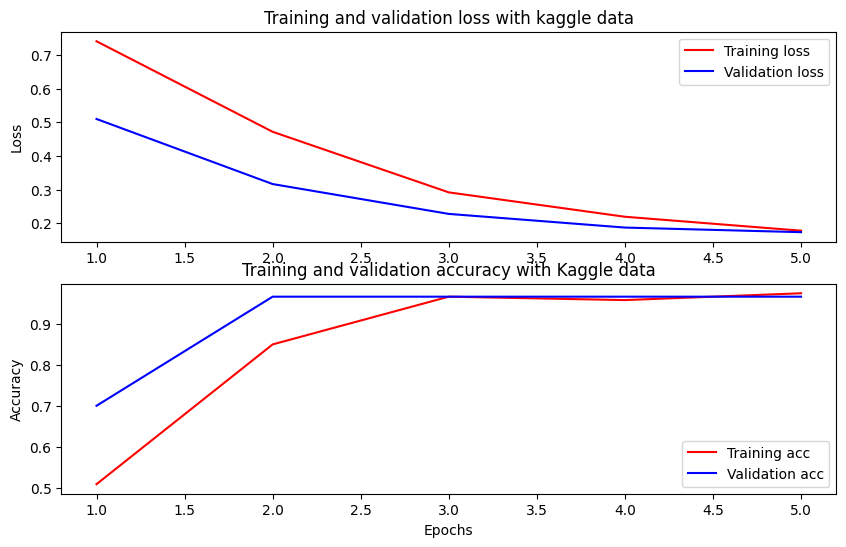

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with kaggle data')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with Kaggle data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'kaggledata'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Reloaded model to save as a 'baseline' without personal data refinement

In [ ]:
reloaded_model = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/NLP Spam/kaggledata_bert')

## Refining the classifier model (reloadedmodel) with personal data

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(per_train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
ploss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
pmetrics = tf.metrics.BinaryAccuracy()

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=ploss,
                         metrics=pmetrics)

In [ ]:
### training with personal test and train data

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=per_train_ds,
                               validation_data=per_val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
4/4 [==============================] - 37s 9s/step - loss: 2.3817 - binary_accuracy: 0.7583 - val_loss: 1.0775 - val_binary_accuracy: 0.9000
Epoch 2/5
4/4 [==============================] - 23s 6s/step - loss: 1.0273 - binary_accuracy: 0.8833 - val_loss: 1.0383 - val_binary_accuracy: 0.9333
Epoch 3/5
4/4 [==============================] - 23s 6s/step - loss: 0.3589 - binary_accuracy: 0.9250 - val_loss: 1.0341 - val_binary_accuracy: 0.9333
Epoch 4/5
4/4 [==============================] - 23s 6s/step - loss: 0.3245 - binary_accuracy: 0.9333 - val_loss: 1.0400 - val_binary_accuracy: 0.9333
Epoch 5/5
4/4 [==============================] - 23s 6s/step - loss: 0.3272 - binary_accuracy: 0.9667 - val_loss: 1.0376 - val_binary_accuracy: 0.9333


In [ ]:
ploss, accuracy = classifier_model.evaluate(per_test_ds)

print(f'Loss: {ploss}')
print(f'Accuracy: {accuracy}')

2/2 [==============================] - 12s 845ms/step - loss: 0.0348 - binary_accuracy: 0.9800
Loss: 0.0348413810133934
Accuracy: 0.9800000190734863


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


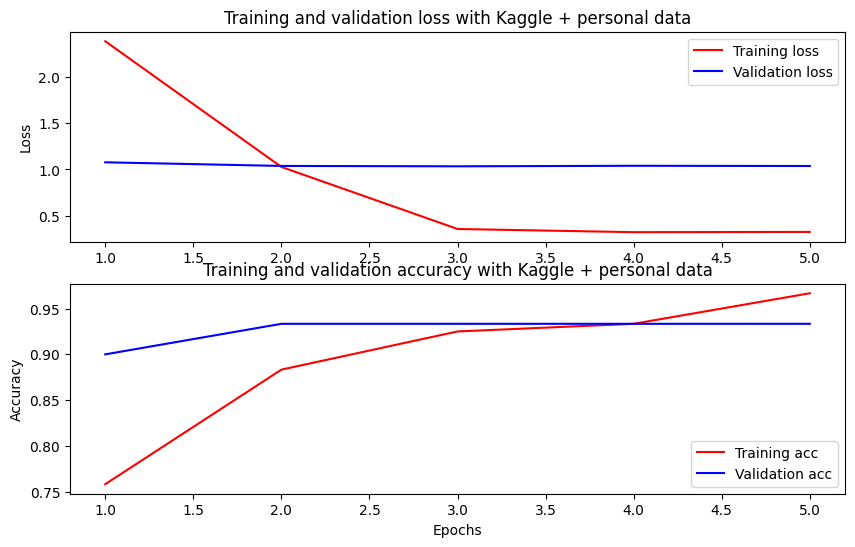

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss with Kaggle + personal data')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with Kaggle + personal data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'Hello, I am Joyce from HR, and we are currently recruiting for open positions. Are you interested?',  # this is the same sentence tried earlier
    'man this final is going to suck lol',
    'Congratulations! You have won a prize! Please verify your identity at the following link',
    'Congratulations on graduating!',
    'I want to go see the cats'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model (without personal data refinement):')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory (refined kaggle and personal data):')
print_my_examples(examples, original_results)

Results from the saved model (without personal data refinement):
input: Hello, I am Joyce from HR, and we are currently recruiting for open positions. Are you interested? : score: 0.191895
input: man this final is going to suck lol : score: 0.216224
input: Congratulations! You have won a prize! Please verify your identity at the following link : score: 0.530953
input: Congratulations on graduating! : score: 0.180382
input: I want to go see the cats      : score: 0.061753

Results from the model in memory (refined kaggle and personal data):
input: Hello, I am Joyce from HR, and we are currently recruiting for open positions. Are you interested? : score: 0.283139
input: man this final is going to suck lol : score: 0.164524
input: Congratulations! You have won a prize! Please verify your identity at the following link : score: 0.725196
input: Congratulations on graduating! : score: 0.201783
input: I want to go see the cats      : score: 0.052721

